In [34]:
!pip install xgboost


In [35]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df = pd.read_csv(r"C:\Users\USER\OneDrive\Desktop\dataset.csv", encoding_errors='ignore')

In [37]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [38]:
df = df.dropna(subset=['CustomerID'])  # Remove rows with missing CustomerID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Convert to datetime
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']  # Total price for each row


In [39]:
reference_date = df['InvoiceDate'].max() + timedelta(days=1)


In [40]:
customer_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

In [41]:
customer_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']  # Avg Order Value


In [42]:
X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['Monetary']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [44]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=4, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [49]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"📈 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")

📈 MAE: 385.10
📉 RMSE: 4685.88


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


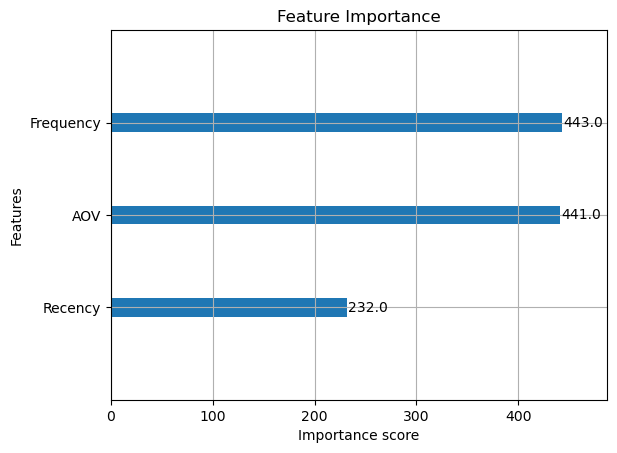

In [58]:
xgb.plot_importance(model)
plt.title("Feature Importance")
plt.show()

In [60]:
customer_df['Predicted_LTV'] = model.predict(X)

In [62]:
customer_df['Segment'] = pd.qcut(customer_df['Predicted_LTV'], 3, labels=['Low', 'Medium', 'High'])

In [64]:
customer_df.to_csv('final_ltv_predictions.csv', index=False)
print("✅ LTV predictions saved to 'final_ltv_predictions.csv'")

✅ LTV predictions saved to 'final_ltv_predictions.csv'


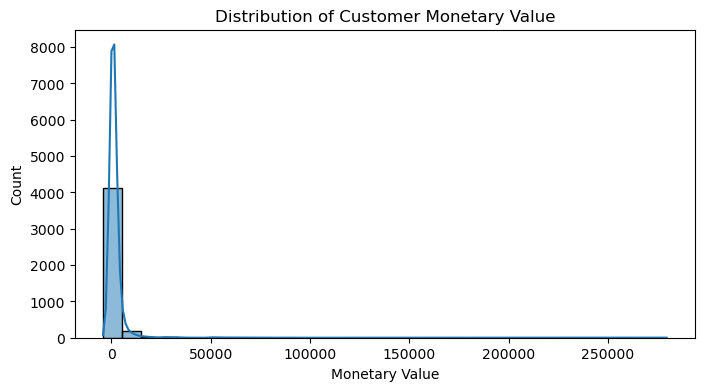

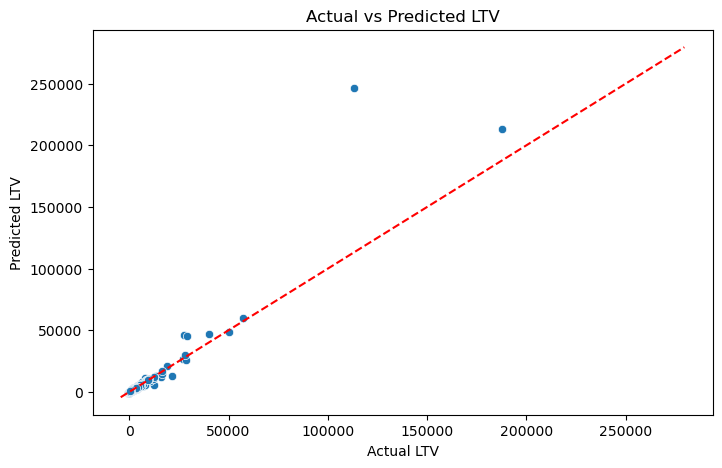

In [66]:
# 🔍 Distribution of Target Variable (Monetary / LTV)
plt.figure(figsize=(8,4))
sns.histplot(customer_df['Monetary'], bins=30, kde=True)
plt.title("Distribution of Customer Monetary Value")
plt.xlabel("Monetary Value")
plt.ylabel("Count")
plt.show()

# 🔍 Predicted vs Actual Plot
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # Diagonal line
plt.show()


In [68]:
print("📈 Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


📈 Model Evaluation Metrics:
Mean Absolute Error (MAE): 385.10
Root Mean Squared Error (RMSE): 4685.88


In [70]:
customer_df.to_csv('final_ltv_predictions.csv', index=False)
